GAN

In [26]:
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Reshape, Conv2D, Conv2DTranspose, 
                                    Flatten, Dropout, BatchNormalization, 
                                    LeakyReLU, Input, Lambda)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import backend as K

# Загрузка и предобработка данных
def load_images(path, target_size=(64, 64), max_images=None):
    images = []
    count = 0
    for root, _, files in os.walk(path):
        for file in files:
            if file.endswith('.jpg'):
                img_path = os.path.join(root, file)
                img = Image.open(img_path)
                img = img.resize(target_size)
                img_array = img_to_array(img)
                images.append(img_array)
                count += 1
                if max_images and count >= max_images:
                    return np.array(images)
    return np.array(images)

# Загрузка изображений и нормализация в [-1, 1]
images = load_images('lfw-deepfunneled', target_size=(64, 64), max_images=5000)
images = (images - 127.5) / 127.5

# Параметры
latent_dim = 256
img_shape = (64, 64, 3)
batch_size = 64

# Функция для визуализации результатов
def sample_images(epoch, generator):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Масштабирование изображений [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig(f"gan_images_{epoch}.png")
    plt.close()

# Генератор
def build_generator(latent_dim):
    model = Sequential()
    
    model.add(Dense(256 * 8 * 8, input_dim=latent_dim))
    model.add(Reshape((8, 8, 256)))
    
    # Блок 1
    model.add(Conv2DTranspose(256, 4, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    
    # Блок 2
    model.add(Conv2DTranspose(128, 4, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    
    # Блок 3
    model.add(Conv2DTranspose(64, 4, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    
    # Выходной слой
    model.add(Conv2DTranspose(3, 4, padding='same', activation='tanh'))
    
    return model

# Дискриминатор
def build_discriminator(input_shape):
    model = Sequential()
    
    # Блок 1
    model.add(Conv2D(64, 4, strides=2, padding='same', input_shape=input_shape))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    
    # Блок 2
    model.add(Conv2D(128, 4, strides=2, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    
    # Блок 3
    model.add(Conv2D(256, 4, strides=2, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    
    # Блок 4
    model.add(Conv2D(512, 4, strides=2, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    
    # Выходной слой
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    return model

# Сборка моделей
generator = build_generator(latent_dim)
discriminator = build_discriminator(img_shape)

# Функция потерь и оптимизатор
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

discriminator.compile(optimizer=Adam(0.0001, 0.5),
                     loss=wasserstein_loss,
                     metrics=['accuracy'])

# Комбинированная модель (GAN)
z = Input(shape=(latent_dim,))
img = generator(z)
discriminator.trainable = False
validity = discriminator(img)
gan = Model(z, validity)
gan.compile(optimizer=Adam(0.0001, 0.5), loss=wasserstein_loss)

# Обучение с Gradient Penalty
def train_gan(epochs, batch_size=64, sample_interval=200):
    valid = -np.ones((batch_size, 1))  # Для Wasserstein loss
    fake = np.ones((batch_size, 1))
    
    for epoch in range(epochs):

        #  Обучение дискриминатора
        for _ in range(5):  # Обновляем дискриминатор чаще
            # Выбор случайных реальных изображений
            idx = np.random.randint(0, images.shape[0], batch_size)
            imgs = images[idx]
            
            # Генерация фейковых изображений
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            gen_imgs = generator.predict(noise, verbose=0)
            
            # Обучение дискриминатора
            d_loss_real = discriminator.train_on_batch(imgs, valid)
            d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        #  Обучение генератора
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, valid)
        
        # Вывод прогресса
        if epoch % sample_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {100*d_loss[1]}] [G loss: {g_loss}]")
            sample_images(epoch, generator)

# Запуск обучения
train_gan(epochs=10000, batch_size=batch_size, sample_interval=200)

0 [D loss: -0.022600753232836723 | D accuracy: 8.776041865348816] [G loss: -0.48640531301498413]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
200 [D loss: 0.007004141807556152 | D accuracy: 43.75038743019104] [G loss: -0.5761527419090271]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
400 [D loss: 0.0461391881108284 | D accuracy: 46.85278534889221] [G loss: -0.6803167462348938]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
600 [D loss: 0.09630338847637177 | D accuracy: 47.90019989013672] [G loss: -0.7525871992111206]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
800 [D loss: 0.1267932653427124 | D accuracy: 48.424527049064636] [G loss: -0.7963458895683289]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1000 [D loss: 0.14620167016983032 | D accuracy: 48.739323019981384] [G loss: -0.8247542381286621]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1200 [D loss: 0.15955737233161926 | D accuracy: 48.94926846027374] [G loss: -0.8444970846176147]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1400 [D loss: 0.16930046677589417 | D accuracy: 49.

VAE

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - loss: 3770.9028

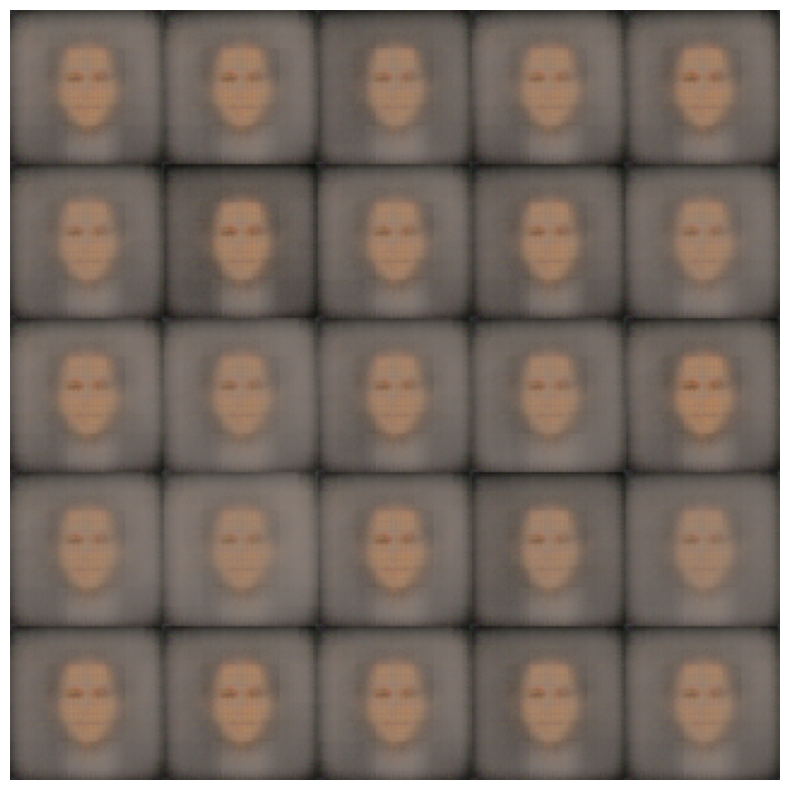

63/63 ━━━━━━━━━━━━━━━━━━━━ 66s 952ms/step - loss: 3763.7415 - val_loss: 2722.5566
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 855ms/step - loss: 2603.2791 - val_loss: 2089.5801
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 852ms/step - loss: 2013.8101 - val_loss: 1795.5431
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 851ms/step - loss: 1731.2061 - val_loss: 1606.9976
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 852ms/step - loss: 1556.5570 - val_loss: 1501.1802
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 853ms/step - loss: 1455.9366 - val_loss: 1439.7228
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 853ms/step - loss: 1393.0094 - val_loss: 1425.5752
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 856ms/step - loss: 1332.1407 - val_loss: 1343.1405
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 852ms/step - loss: 1282.6404 - val_loss: 1338.3503
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 852ms/step - loss: 1258.6831 - val_loss: 1349.7648
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - loss: 1217.5116

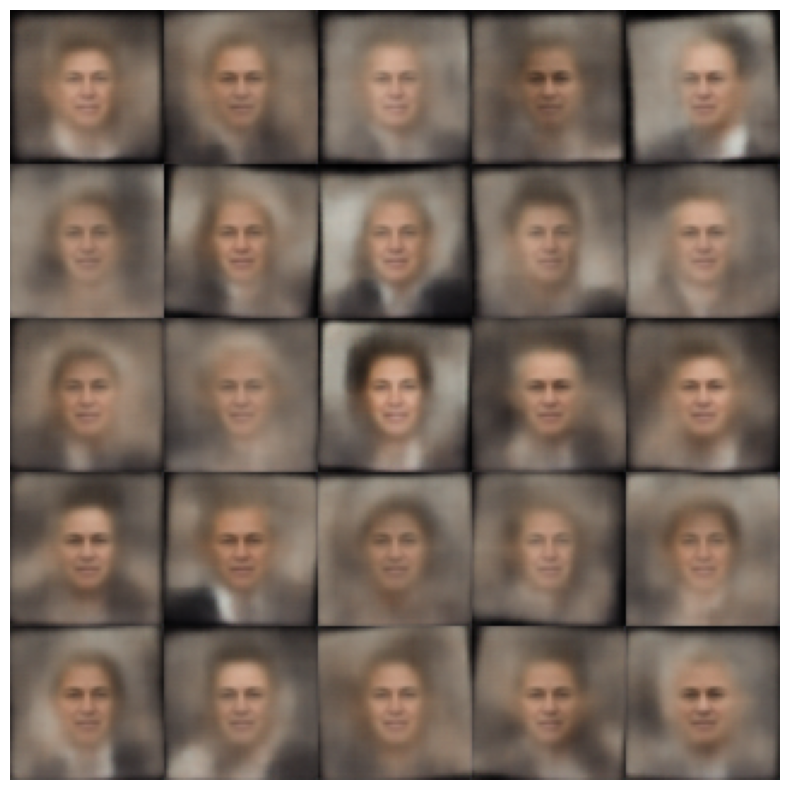

63/63 ━━━━━━━━━━━━━━━━━━━━ 59s 930ms/step - loss: 1217.3350 - val_loss: 1281.2753
Epoch 12/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 852ms/step - loss: 1181.3368 - val_loss: 1247.8524
Epoch 13/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 851ms/step - loss: 1151.4435 - val_loss: 1231.2264
Epoch 14/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 850ms/step - loss: 1125.0526 - val_loss: 1231.2664
Epoch 15/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 851ms/step - loss: 1099.2367 - val_loss: 1191.1333
Epoch 16/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 855ms/step - loss: 1064.0142 - val_loss: 1156.6770
Epoch 17/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 851ms/step - loss: 1026.6239 - val_loss: 1161.7964
Epoch 18/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 854ms/step - loss: 1006.3152 - val_loss: 1186.3855
Epoch 19/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 853ms/step - loss: 999.5610 - val_loss: 1139.9949
Epoch 20/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 851ms/step - loss: 999.5208 - val_loss: 1133.0458
Epoch 21/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 786ms/step - loss: 975

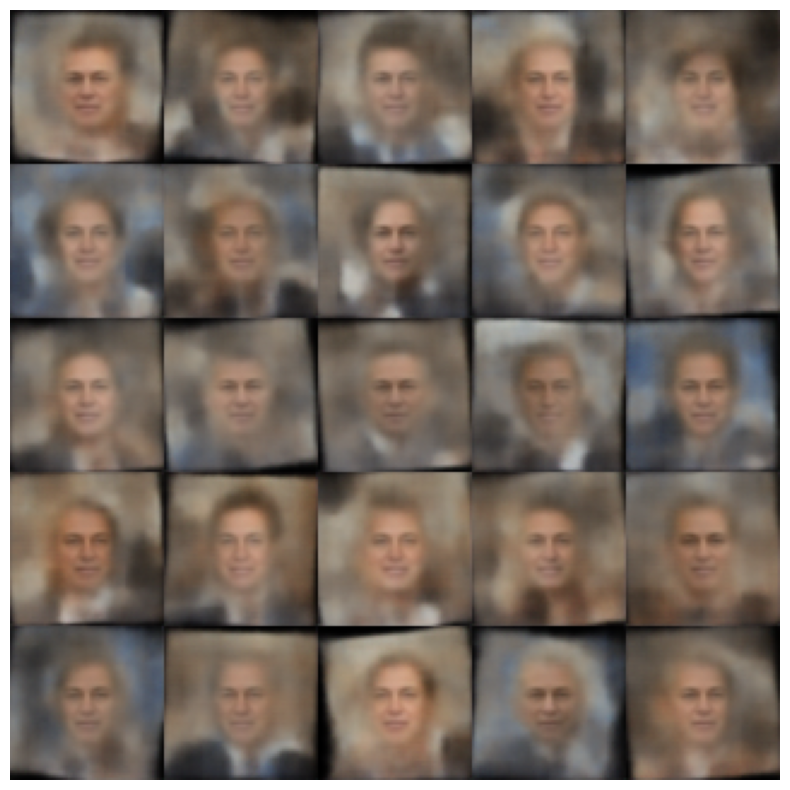

63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 930ms/step - loss: 975.8138 - val_loss: 1120.0720
Epoch 22/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 852ms/step - loss: 958.7250 - val_loss: 1135.7733
Epoch 23/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 849ms/step - loss: 945.6857 - val_loss: 1171.1185
Epoch 24/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 851ms/step - loss: 930.7154 - val_loss: 1116.6786
Epoch 25/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 53s 849ms/step - loss: 905.8474 - val_loss: 1130.0911
Epoch 26/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 851ms/step - loss: 904.5121 - val_loss: 1143.9537
Epoch 27/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 875ms/step - loss: 914.0789 - val_loss: 1154.3571
Epoch 28/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 53s 845ms/step - loss: 888.8568 - val_loss: 1120.7743
Epoch 29/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 851ms/step - loss: 849.1214 - val_loss: 1140.6813
Epoch 30/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 854ms/step - loss: 838.0623 - val_loss: 1142.0765
Epoch 31/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 793ms/step - loss: 830.9128

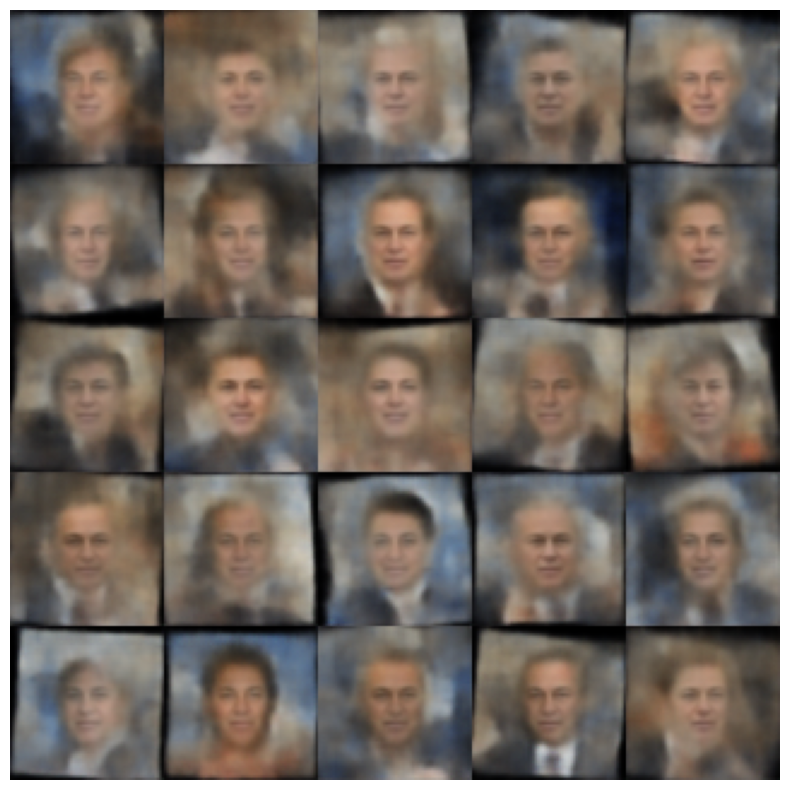

63/63 ━━━━━━━━━━━━━━━━━━━━ 59s 938ms/step - loss: 831.0206 - val_loss: 1170.9828
Epoch 32/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 880ms/step - loss: 847.3974 - val_loss: 1157.1361
Epoch 33/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 882ms/step - loss: 891.4160 - val_loss: 1211.8101
Epoch 34/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 892ms/step - loss: 870.9030 - val_loss: 1112.8464
Epoch 35/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 894ms/step - loss: 790.8974 - val_loss: 1128.0312
Epoch 36/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 891ms/step - loss: 774.9633 - val_loss: 1168.2590
Epoch 37/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 888ms/step - loss: 780.6183 - val_loss: 1198.9293
Epoch 38/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 53s 849ms/step - loss: 785.5441 - val_loss: 1211.0579
Epoch 39/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 850ms/step - loss: 797.8793 - val_loss: 1151.8113
Epoch 40/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 857ms/step - loss: 834.2798 - val_loss: 1203.8080
Epoch 41/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 788ms/step - loss: 820.8503

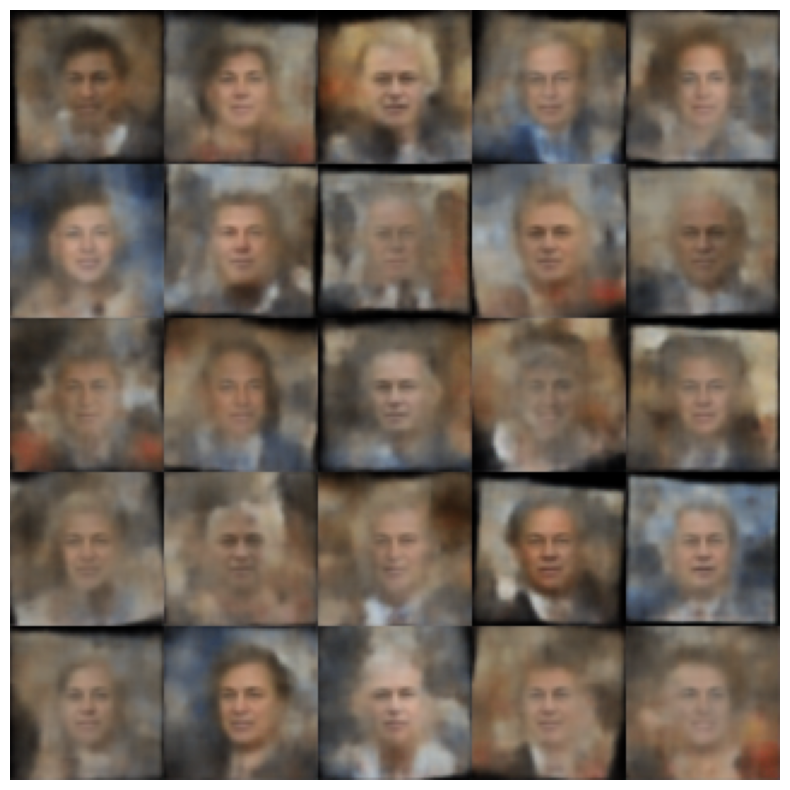

63/63 ━━━━━━━━━━━━━━━━━━━━ 59s 933ms/step - loss: 820.6332 - val_loss: 1137.3644
Epoch 42/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 852ms/step - loss: 764.7549 - val_loss: 1130.8344
Epoch 43/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 53s 848ms/step - loss: 724.2123 - val_loss: 1136.3577
Epoch 44/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 855ms/step - loss: 721.9260 - val_loss: 1138.2013
Epoch 45/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 884ms/step - loss: 718.4379 - val_loss: 1152.1729
Epoch 46/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 859ms/step - loss: 713.0048 - val_loss: 1184.5392
Epoch 47/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 53s 849ms/step - loss: 710.9687 - val_loss: 1184.4918
Epoch 48/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 856ms/step - loss: 702.9346 - val_loss: 1182.3522
Epoch 49/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 855ms/step - loss: 693.2060 - val_loss: 1179.3372
Epoch 50/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 853ms/step - loss: 690.4333 - val_loss: 1200.8381
Epoch 51/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - loss: 693.5188

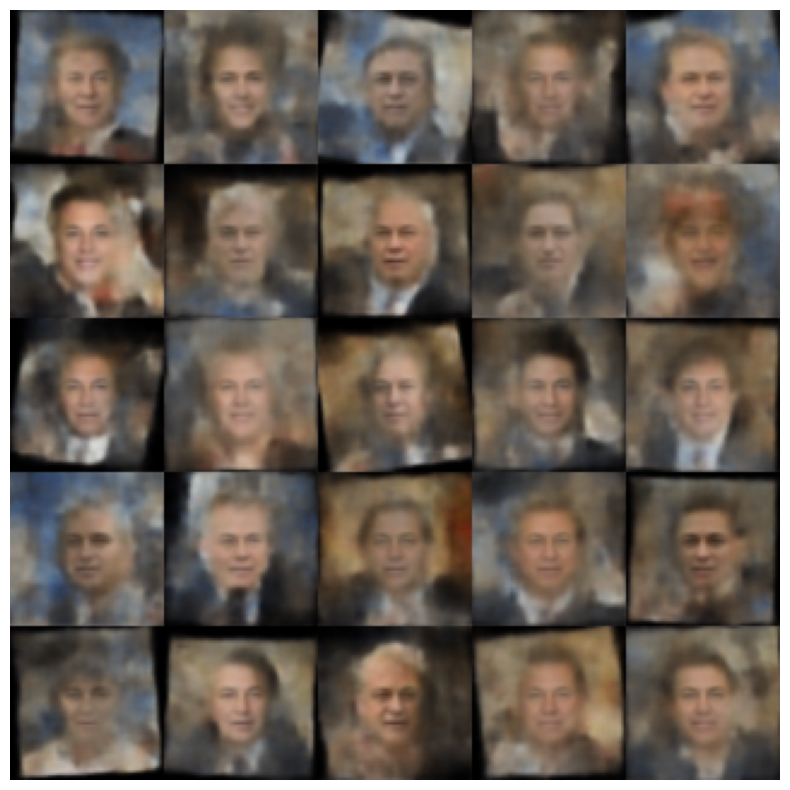

63/63 ━━━━━━━━━━━━━━━━━━━━ 59s 931ms/step - loss: 693.5651 - val_loss: 1240.6233
Epoch 52/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 53s 850ms/step - loss: 710.5267 - val_loss: 1185.3088
Epoch 53/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 53s 848ms/step - loss: 752.9608 - val_loss: 1274.3641
Epoch 54/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 856ms/step - loss: 755.8978 - val_loss: 1248.4183
Epoch 55/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 856ms/step - loss: 707.8727 - val_loss: 1297.4458
Epoch 56/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 53s 845ms/step - loss: 697.2984 - val_loss: 1231.6476
Epoch 57/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 856ms/step - loss: 701.9725 - val_loss: 1181.8445
Epoch 58/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 854ms/step - loss: 675.1072 - val_loss: 1164.6968
Epoch 59/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 53s 846ms/step - loss: 649.8777 - val_loss: 1159.4692
Epoch 60/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 854ms/step - loss: 639.7928 - val_loss: 1183.8538
Epoch 61/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 779ms/step - loss: 640.2819

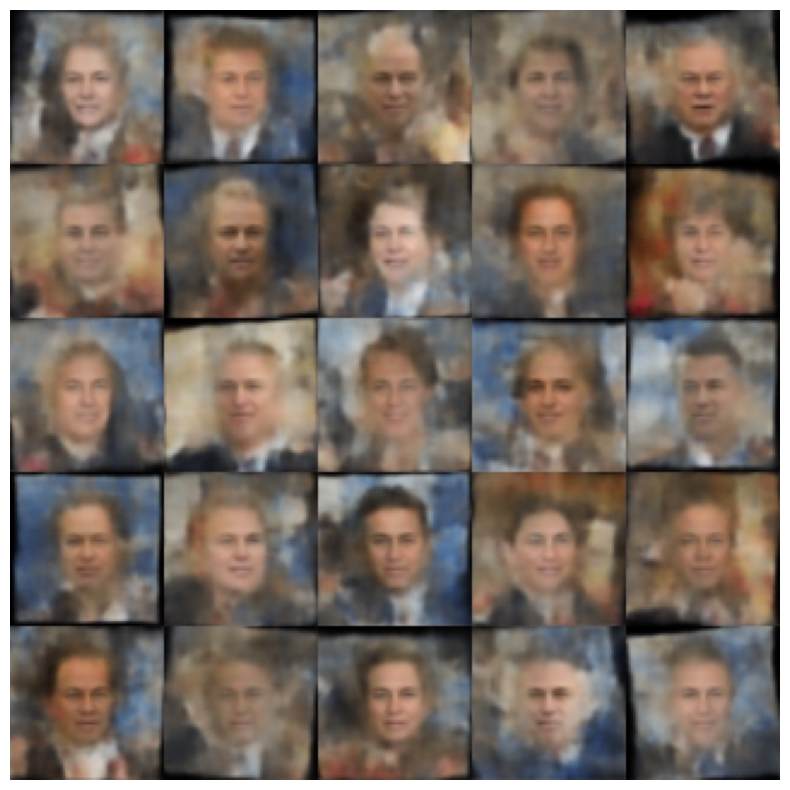

63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 925ms/step - loss: 640.3411 - val_loss: 1181.3032
Epoch 62/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 53s 840ms/step - loss: 640.2743 - val_loss: 1205.1858
Epoch 63/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 857ms/step - loss: 644.1712 - val_loss: 1201.7646
Epoch 64/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 855ms/step - loss: 643.1351 - val_loss: 1251.0125
Epoch 65/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 858ms/step - loss: 635.0921 - val_loss: 1244.8444
Epoch 66/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 855ms/step - loss: 636.0991 - val_loss: 1202.3997
Epoch 67/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 850ms/step - loss: 636.5596 - val_loss: 1185.7731
Epoch 68/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 854ms/step - loss: 616.8300 - val_loss: 1217.0061
Epoch 69/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 854ms/step - loss: 613.2849 - val_loss: 1268.5828
Epoch 70/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 853ms/step - loss: 633.9327 - val_loss: 1213.7698
Epoch 71/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 795ms/step - loss: 659.8427

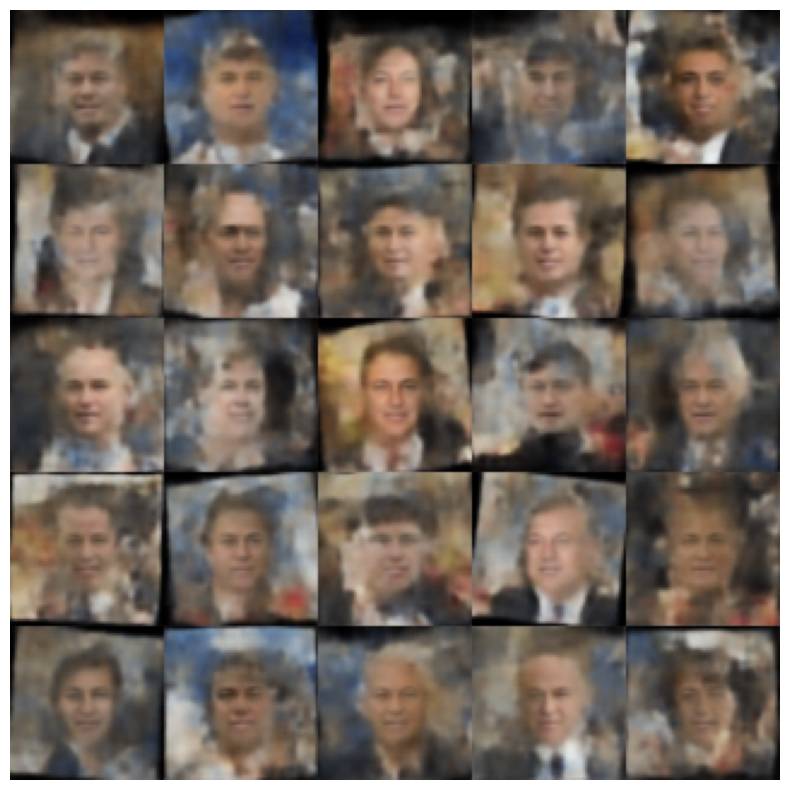

63/63 ━━━━━━━━━━━━━━━━━━━━ 59s 935ms/step - loss: 659.8359 - val_loss: 1286.9360
Epoch 72/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 855ms/step - loss: 685.5113 - val_loss: 1325.5293
Epoch 73/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 852ms/step - loss: 664.4482 - val_loss: 1195.1688
Epoch 74/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 852ms/step - loss: 597.2517 - val_loss: 1172.2639
Epoch 75/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 855ms/step - loss: 557.6511 - val_loss: 1191.0251
Epoch 76/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 854ms/step - loss: 544.8269 - val_loss: 1199.7698
Epoch 77/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 854ms/step - loss: 540.3910 - val_loss: 1196.9797
Epoch 78/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 856ms/step - loss: 542.5871 - val_loss: 1196.6439
Epoch 79/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 858ms/step - loss: 550.9294 - val_loss: 1244.2288
Epoch 80/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 855ms/step - loss: 562.6759 - val_loss: 1274.7079
Epoch 81/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 794ms/step - loss: 577.2586

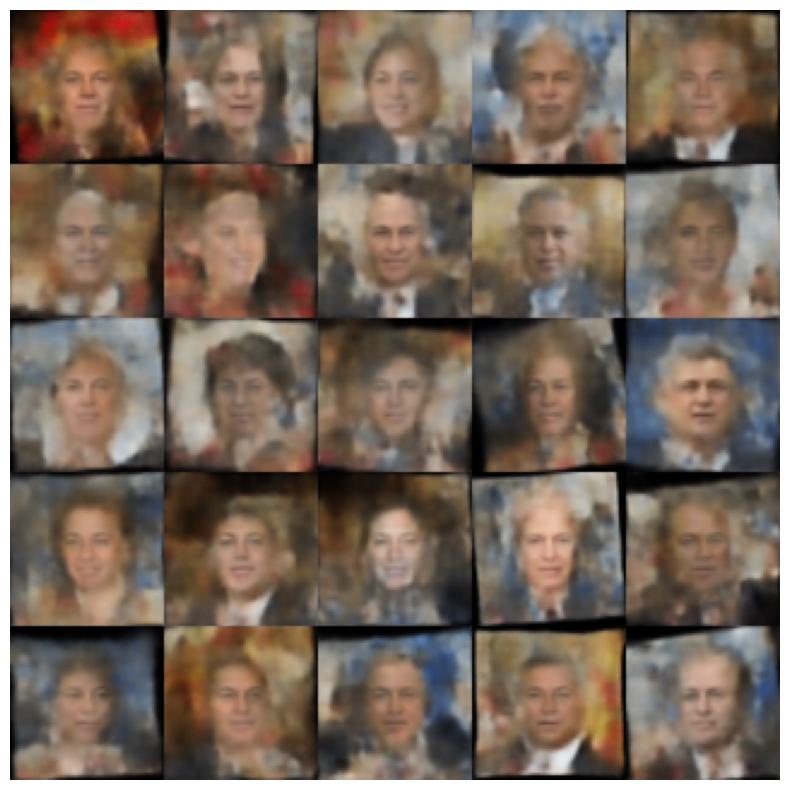

63/63 ━━━━━━━━━━━━━━━━━━━━ 59s 935ms/step - loss: 577.2131 - val_loss: 1285.3644
Epoch 82/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 856ms/step - loss: 587.1085 - val_loss: 1253.9398
Epoch 83/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 855ms/step - loss: 588.3498 - val_loss: 1218.8097
Epoch 84/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 852ms/step - loss: 596.2097 - val_loss: 1224.6469
Epoch 85/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 855ms/step - loss: 592.5167 - val_loss: 1226.4648
Epoch 86/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 855ms/step - loss: 582.0343 - val_loss: 1229.8810
Epoch 87/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 855ms/step - loss: 562.5508 - val_loss: 1223.0344
Epoch 88/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 857ms/step - loss: 541.2700 - val_loss: 1235.1200
Epoch 89/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 858ms/step - loss: 534.8908 - val_loss: 1299.2040
Epoch 90/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 850ms/step - loss: 547.2304 - val_loss: 1371.4167
Epoch 91/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 793ms/step - loss: 574.7039

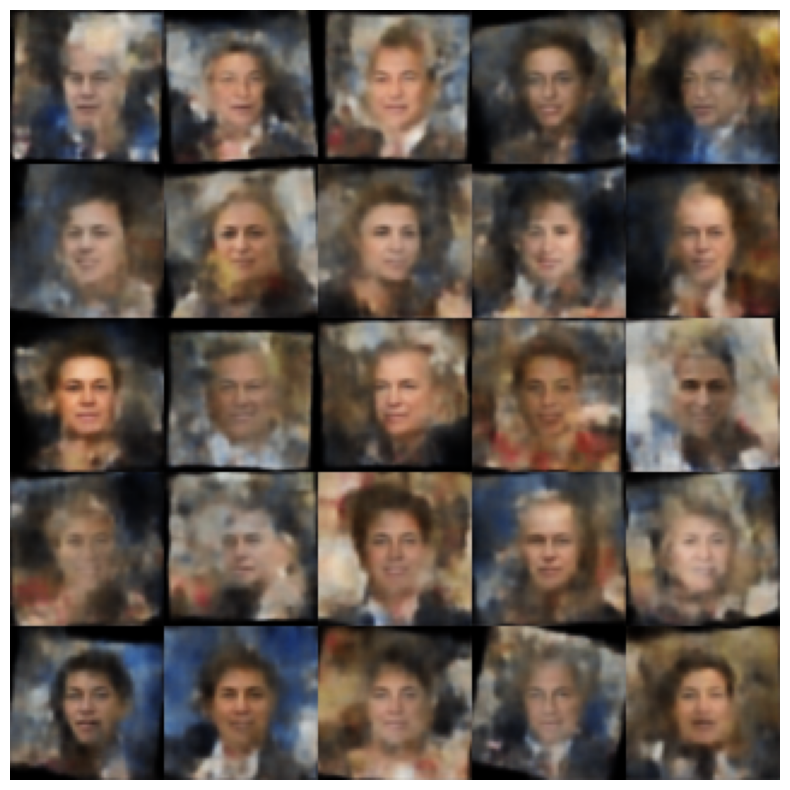

63/63 ━━━━━━━━━━━━━━━━━━━━ 59s 934ms/step - loss: 574.6973 - val_loss: 1363.9829
Epoch 92/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 858ms/step - loss: 605.1829 - val_loss: 1359.8646
Epoch 93/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 854ms/step - loss: 632.4727 - val_loss: 1320.3788
Epoch 94/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 856ms/step - loss: 625.2112 - val_loss: 1379.2993
Epoch 95/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 854ms/step - loss: 603.0409 - val_loss: 1319.6443
Epoch 96/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 855ms/step - loss: 559.2814 - val_loss: 1228.5317
Epoch 97/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 855ms/step - loss: 511.2908 - val_loss: 1206.4458
Epoch 98/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 876ms/step - loss: 486.1715 - val_loss: 1202.0178
Epoch 99/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 869ms/step - loss: 472.9800 - val_loss: 1204.7291
Epoch 100/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 890ms/step - loss: 470.4713 - val_loss: 1220.8424


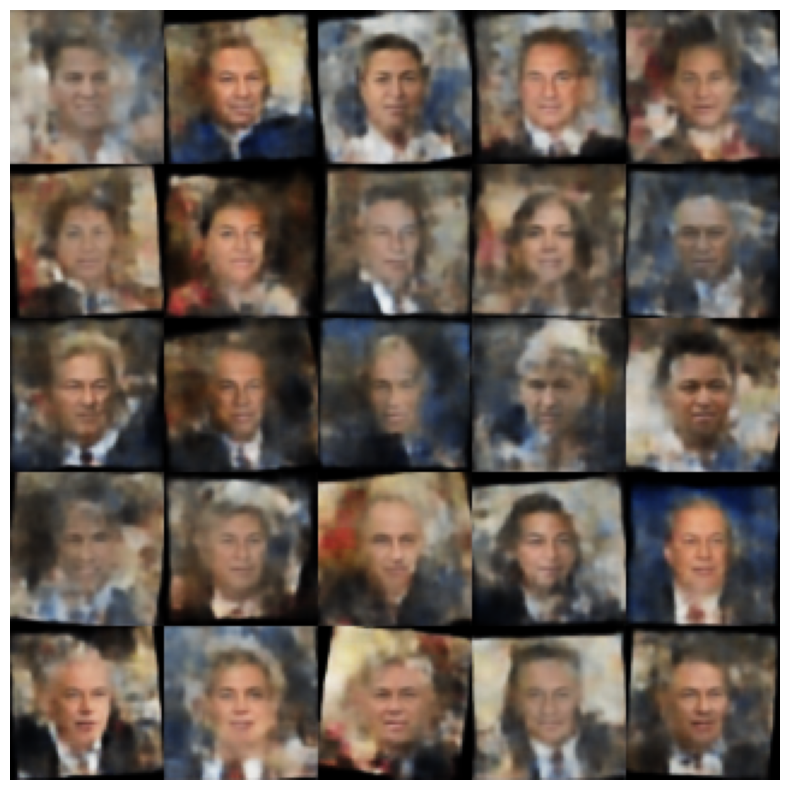

In [27]:
import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError

# Параметры
img_shape = (64, 64, 3)
intermediate_dim = 512
latent_dim = 256
batch_size = 64
epochs = 100

# Функция для sampling
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Энкодер
inputs = Input(shape=img_shape)
x = Conv2D(64, 3, activation='relu', strides=2, padding='same')(inputs)
x = Conv2D(128, 3, activation='relu', strides=2, padding='same')(x)
x = Conv2D(256, 3, activation='relu', strides=2, padding='same')(x)
x = Flatten()(x)
x = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)
z = Lambda(sampling)([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

# Декодер
latent_inputs = Input(shape=(latent_dim,))
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
x = Dense(8 * 8 * 256, activation='relu')(x)
x = Reshape((8, 8, 256))(x)
x = Conv2DTranspose(256, 3, activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
outputs = Conv2DTranspose(3, 3, activation='tanh', padding='same')(x)
decoder = Model(latent_inputs, outputs, name='decoder')

# VAE модель
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

# Кастомная функция потерь
class VAELoss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
        self.mse = MeanSquaredError()
    
    def call(self, y_true, y_pred):
        # Reconstruction loss
        reconstruction_loss = self.mse(Flatten()(y_true), Flatten()(y_pred))
        reconstruction_loss *= img_shape[0] * img_shape[1] * img_shape[2]
        
        # KL divergence
        z_mean, z_log_var, _ = encoder(y_true)
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        
        return reconstruction_loss + kl_loss

vae.compile(optimizer=Adam(0.0005), loss=VAELoss())

# Callback для сохранения изображений
class SaveImageCallback(tf.keras.callbacks.Callback):
    def __init__(self, decoder):
        super().__init__()
        self.decoder = decoder
    
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            generate_images(self.decoder, epoch)

def generate_images(decoder, epoch=None, n=5):
    figure = np.zeros((64 * n, 64 * n, 3))
    for i in range(n):
        for j in range(n):
            z_sample = np.random.normal(size=(1, latent_dim))
            x_decoded = decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(64, 64, 3)
            figure[i*64:(i+1)*64, j*64:(j+1)*64] = (digit + 1) / 2  # Масштабирование [0,1]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(figure)
    plt.axis('off')
    if epoch is not None:
        plt.savefig(f"vae_images_{epoch}.png")
    plt.show()

# Обучение модели
vae.fit(images, images,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[SaveImageCallback(decoder)])

# Генерация новых изображений после обучения
generate_images(decoder)

## Выводы о качестве генерации

### GAN

* Качество изображений: GAN показал способность генерировать относительно реалистичные лица, уже после 200 эпох. Но изображения выглядят размытыми.

* Стабильность обучения: Модель демонстрирует стабильное снижение потерь как генератора, так и дискриминатора, что указывает на успешное обучение.

* Разнообразие: Генератор создает разнообразные лица, но некоторые варианты могут быть похожими друг на друга.

### VAE

* Качество изображений: VAE генерирует более размытые изображения по сравнению с GAN. Это связано с тем, что VAE оптимизирует нижнюю границу вероятности данных, что часто приводит к менее четким результатам.

* Стабильность обучения: Потери снижаются, но качество генерации не достигает уровня GAN. Это особенно заметно в деталях лиц.

* Разнообразие: VAE обеспечивает хорошее разнообразие, но из-за размытости лица выглядят менее реалистичными.

## Предложения по улучшению моделей

### Для GAN

Использование более современных архитектур:

* Замена DCGAN на StyleGAN или ProGAN для улучшения качества генерации.

* Применение архитектуры WGAN-GP для большей стабильности обучения.

Увеличение размера выборки:

* Использование большего количества изображений (всего датасета LFW) для улучшения разнообразия.

Оптимизация гиперпараметров:

* Подбор learning rate, коэффициентов для loss-функций.

* Увеличение количества слоев или нейронов в сети.

Добавление регуляризации:

* Использование dropout, batch normalization для предотвращения переобучения.

Увеличение количества эпох:

* GAN может потребовать больше времени для обучения, чтобы достичь лучшего качества.

### Для VAE

Увеличение емкости модели:

* Добавление большего количества слоев или увеличение размерности латентного пространства.

Использование β-VAE:

* Введение коэффициента β для баланса между реконструкцией и KL-дивергенцией.

Применение VQ-VAE:

* Использование векторного квантования для улучшения качества генерации.

Улучшение функции потерь:

* Замена MSE на SSIM или perceptual loss для улучшения детализации.

Увеличение размера выборки и эпох:

* Как и в случае с GAN, больше данных и времени на обучение могут улучшить результаты.